In [1]:
"""Bayesian way"""
import arviz as az
import stan
import nest_asyncio
nest_asyncio.apply()

"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
plt.style.use("ggplot")
# plt.rcParams["axes.grid"] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.signal import medfilt
from statsmodels.graphics.tsaplots import plot_acf


import warnings
warnings.simplefilter("ignore")

weather_columns = ["date", "day_of_week", "mean_press", "min_press_sea", "mean_press_sea", "mean_vapor", "mean_hum",
                    "min_hum", "total_preci", "hourly_max_preci", "max_depth", "total_snowfall", "sun_hour",
                    "mean_temp", "max_temp", "min_temp", "mean_wind_speed", "max_wind_speed", "max_gust", 
                    "most_direction", "most_direction_dummy"]

In [2]:
df_weather = pl.read_csv("../../data/weather/weather.csv")
df_hrv = pl.read_csv("../../data/HRV/hrv.csv")
df = df_hrv.join(df_weather, on="date")

# convert day of week into dummy variable
days_of_week = ["日", "月", "火", "水", "木", "金", "土"]
day_to_label = {day: idx for idx, day in enumerate(days_of_week)}
df = df.with_columns(
    pl.col("day_of_week").apply(lambda day: day_to_label[day]).alias("day_of_week")
)
df.head()

date,VLF,LF,HF,LFHFratio,HR,SDNN,RMSSD,pNN50,TINN,CD,ApEn,SD1,SD2,SD1SD2ratio,day_of_week,mean_press,min_press_sea,mean_press_sea,mean_vapor,mean_hum,min_hum,total_preci,hourly_max_preci,max_depth,total_snowfall,sun_hour,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,max_gust,most_direction,most_direction_dummy
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,str,i64
"""2017-07-24""",884.554467,176.079683,98.624315,1.785358,89.918794,50.293799,20.861884,0.024854,226.5625,0.208329,0.922786,14.75156,69.499062,0.212256,1,978.5,1000.6,1002.5,29.1,99,93,50.5,8.0,0,0,0.0,23.7,25.1,23.1,0.9,2.9,4.0,"""北北西""",15
"""2017-07-25""",1077.163019,409.565229,692.82705,0.591151,88.932674,60.827421,57.237082,0.122433,156.25,0.207682,0.901482,40.472728,75.529353,0.535854,2,979.6,1002.1,1003.6,28.6,95,85,8.0,1.5,0,0,0.0,24.1,25.7,22.3,0.9,2.2,3.2,"""北北西""",15
"""2017-07-26""",833.683813,284.855324,167.546255,1.700159,93.593945,51.727819,27.178771,0.031002,195.3125,0.145424,0.634698,19.218055,70.521594,0.272513,3,983.1,1004.9,1007.2,24.0,73,51,0.0,0.0,0,0,10.2,25.9,31.5,22.0,2.1,5.3,9.7,"""東南東""",5
"""2017-07-27""",1636.069588,293.085583,222.901403,1.314866,83.92394,75.542652,38.155843,0.062075,304.6875,0.16728,0.728771,26.979802,102.905323,0.262181,4,986.1,1008.8,1010.2,21.9,68,54,0.0,0.0,0,0,4.7,25.4,30.3,21.0,2.7,5.0,7.9,"""東""",4
"""2017-07-28""",994.366727,335.918425,517.969574,0.648529,90.402819,59.249159,41.522311,0.053435,171.875,0.140829,0.58117,29.360692,78.456813,0.374227,5,984.8,1006.4,1008.8,28.0,84,57,39.5,27.5,0,0,2.5,26.1,32.1,22.6,1.5,6.4,10.0,"""北西""",14


In [3]:
y_filter = df["RMSSD"][0:400].rolling_mean(3, center=True).to_numpy()
# y = medfilt(df["RMSSD"][0:200], 5)
y = df["RMSSD"][0:400].to_numpy()
features = df[weather_columns][0:400].drop(["date", "most_direction"])
features.head()

day_of_week,mean_press,min_press_sea,mean_press_sea,mean_vapor,mean_hum,min_hum,total_preci,hourly_max_preci,max_depth,total_snowfall,sun_hour,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,max_gust,most_direction_dummy
i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64
1,978.5,1000.6,1002.5,29.1,99,93,50.5,8.0,0,0,0.0,23.7,25.1,23.1,0.9,2.9,4.0,15
2,979.6,1002.1,1003.6,28.6,95,85,8.0,1.5,0,0,0.0,24.1,25.7,22.3,0.9,2.2,3.2,15
3,983.1,1004.9,1007.2,24.0,73,51,0.0,0.0,0,0,10.2,25.9,31.5,22.0,2.1,5.3,9.7,5
4,986.1,1008.8,1010.2,21.9,68,54,0.0,0.0,0,0,4.7,25.4,30.3,21.0,2.7,5.0,7.9,4
5,984.8,1006.4,1008.8,28.0,84,57,39.5,27.5,0,0,2.5,26.1,32.1,22.6,1.5,6.4,10.0,14


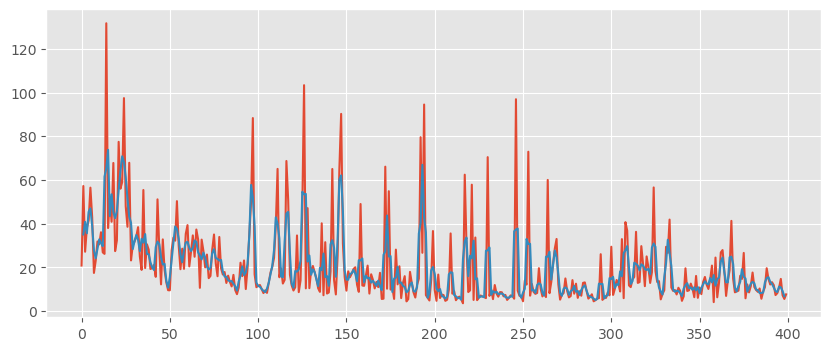

In [4]:
plt.figure(figsize=(10,4))
plt.plot(y)
plt.plot(y_filter)
# plt.plot(medfilt(y, 3))
# plt.plot(pl.Series(y)[:].rolling_mean(4, center=True))
# plt.plot()


In [5]:
scaler = StandardScaler()
features_std = scaler.fit_transform(features.drop(["day_of_week", "most_direction_dummy"]).to_numpy())
features_std = pl.DataFrame(features_std, schema=features.columns[1:-1])
features_std.describe()

statistic,mean_press,min_press_sea,mean_press_sea,mean_vapor,mean_hum,min_hum,total_preci,hourly_max_preci,max_depth,total_snowfall,sun_hour,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,max_gust
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",9.6811e-15,-1.4229e-14,-5.4712e-15,NaN,NaN,NaN,-3.5527e-17,-3.3307e-17,2.6645e-17,5.5511e-18,8.8818e-18,2.3093e-16,7.1054e-17,-1.1546e-16,9.7700e-17,4.4409e-17,7.9936e-17
"""std""",1.001252,1.001252,1.001252,NaN,NaN,NaN,1.001252,1.001252,1.001252,1.001252,1.001252,1.001252,1.001252,1.001252,1.001252,1.001252,1.001252
"""min""",-3.327022,-4.694144,-3.261818,-1.379803,-2.997174,-2.704845,-0.439083,-0.471728,-0.417833,-0.193855,-1.170981,-2.061343,-1.997163,-2.27593,-1.295779,-1.77079,-1.606912
"""25%""",-0.666223,-0.556176,-0.654942,-0.969889,-0.685235,-0.706104,-0.439083,-0.471728,-0.417833,-0.193855,-0.999794,-0.991878,-0.893977,-0.974764,-0.639095,-0.717157,-0.678061
"""50%""",-0.004959,0.036803,0.003939,-0.100374,0.085412,0.043424,-0.439083,-0.471728,-0.417833,-0.193855,-0.192769,0.179441,0.209208,0.119867,-0.263846,-0.075816,-0.125771
"""75%""",0.703537,0.668456,0.734437,0.930621,0.759727,0.730491,0.056182,0.167903,-0.417833,-0.193855,0.736532,0.851676,0.826244,0.925351,0.392838,0.565526,0.552039
"""max""",2.939238,2.808339,2.925932,1.936774,2.012028,2.479389,7.423241,9.922286,4.92331,14.718045,2.228306,1.595209,1.667656,1.627568,4.520568,3.863853,4.618901


In [6]:
n_sample = len(features) # number of samples
y = y # medfilt(y, 11)
# data for stan code
data = {
    "n_sample": n_sample,
    "mean_press": features_std["mean_press"].to_numpy(), 
    "mean_hum": features_std["mean_hum"].to_numpy(),
    "mean_temp": features_std["mean_temp"].to_numpy(),
    "mean_wind_speed": features_std["mean_wind_speed"].to_numpy(),
    "sun_hour": features_std["sun_hour"].to_numpy(),
    "total_preci": features_std["total_preci"].to_numpy(),
    "total_snowfall": features_std["total_snowfall"].to_numpy(),
    "y": y
}
# (features_std["mean_press"]-features_std.with_columns(pl.col("mean_press").rolling_mean(7))["mean_press"]).to_numpy()

In [7]:
# https://discourse.mc-stan.org/t/pystan-init-values/26008
init_dict = {}
init_dict["mu"] = y
init_dict["sigma_w"] = 10
init_dict["sigma_v"] = 10
init_dict["b_1"] = 1
def stan_init(init_dict: dict):
    res = {}
    for name, dict_ in init_dict.items():
        res[name] = dict_
    return res

In [8]:
features_std

mean_press,min_press_sea,mean_press_sea,mean_vapor,mean_hum,min_hum,total_preci,hourly_max_preci,max_depth,total_snowfall,sun_hour,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,max_gust
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-1.658118,-1.278065,-1.686234,1.800136,2.012028,2.416928,5.813631,2.086798,-0.417833,-0.193855,-1.170981,0.943344,0.499028,1.348746,-1.201967,-1.266878,-1.355872
-1.48493,-1.084702,-1.528675,1.738028,1.626705,1.917243,0.551446,0.007995,-0.417833,-0.193855,-1.170981,0.984086,0.555122,1.266133,-1.201967,-1.587549,-1.556704
-0.933877,-0.723758,-1.013029,1.166633,-0.492573,-0.206419,-0.439083,-0.471728,-0.417833,-0.193855,1.32346,1.167423,1.097366,1.235153,-0.076222,-0.167436,0.075061
-0.461546,-0.221014,-0.583324,0.905778,-0.974227,-0.019037,-0.439083,-0.471728,-0.417833,-0.193855,-0.021582,1.116496,0.985177,1.131885,0.48665,-0.304866,-0.376812
-0.666223,-0.530395,-0.783853,1.663498,0.567066,0.168345,4.451654,8.323207,-0.417833,-0.193855,-0.559598,1.187794,1.15346,1.297113,-0.639095,0.336475,0.150373
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.860981,0.913382,0.806055,-0.112796,1.145051,1.105254,-0.191451,0.007995,-0.417833,-0.193855,-1.097615,-0.115935,-0.314338,0.109541,-1.108155,-1.358499,-1.280559
1.270334,1.235654,1.221436,-0.410915,0.470735,-0.706104,-0.439083,-0.471728,-0.417833,-0.193855,0.687622,-0.248345,-0.015169,-0.241568,-0.639095,-0.579727,-0.678061
1.522244,1.454799,1.479259,-0.485445,0.470735,0.168345,-0.439083,-0.471728,-0.417833,-0.193855,0.467524,-0.350199,-0.080612,-0.448102,-1.014343,-1.266878,-1.280559


In [9]:
with open("model/basic.stan", "r") as fstan:
    posterior = stan.build(fstan.read(), data=data, random_seed=1023)
fit = posterior.sample(num_chains=4, num_samples=1000, num_warmup=1000,)
                        # init=[stan_init(init_dict)]*4)
result = fit.to_frame()
result = result.drop(['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'], axis=1)

Building...



Building: 12.6s, done.Messages from stanc:
Warning in '/tmp/httpstan_1ia7y4og/model_g5bcu2iu.stan', line 52, column 19: Argument
    40 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_1ia7y4og/model_g5bcu2iu.stan', line 50, column 16: Argument
    40 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fa

RuntimeError: Exception during call to services function: `RuntimeError("Initialization between (-2, 2) failed after 100 attempts. Try specifying initial values, reducing ranges of constrained values, or reparameterizing the model. Initialization failed. Rejecting initial value: Error evaluating the log probability at the initial value. Exception: model_g5bcu2iu_namespace::log_prob: alpha[1] is nan, but must be greater than or equal to -100.000000 (in '/tmp/httpstan_y_seys17/model_g5bcu2iu.stan', line 35, column 4 to column 50) Rejecting initial value:")`, traceback: `['  File "/home/kota/anaconda3/envs/pystan/lib/python3.11/asyncio/tasks.py", line 277, in __step\n    result = coro.send(None)\n             ^^^^^^^^^^^^^^^\n', '  File "/home/kota/anaconda3/envs/pystan/lib/python3.11/site-packages/httpstan/services_stub.py", line 182, in call\n    raise RuntimeError(exception_message)\n']`

In [ ]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],33.514,5.553,22.900,43.654,0.313,0.229,300.0,818.0,1.02
mu[1],34.067,5.015,25.581,43.223,0.310,0.225,265.0,841.0,1.01
mu[2],34.132,4.668,26.468,42.909,0.299,0.217,258.0,1024.0,1.01
mu[3],34.640,4.285,27.256,42.379,0.310,0.222,206.0,984.0,1.01
mu[4],34.781,4.240,27.652,42.474,0.305,0.218,209.0,902.0,1.02
...,...,...,...,...,...,...,...,...,...
mu[398],9.451,1.703,6.324,12.526,0.115,0.082,220.0,1161.0,1.04
mu[399],9.410,1.816,5.762,12.424,0.115,0.081,241.0,1316.0,1.03
mu_zero,33.441,5.886,23.246,44.825,0.325,0.239,302.0,857.0,1.01
sigma_w,0.145,0.059,0.030,0.243,0.021,0.016,7.0,13.0,1.53


In [ ]:
mu_name = [f"mu.{i}" for i in range(1, n_sample+1)]
result_mu = result[mu_name].values
# result_mu[:, 0] # 1時点のサンプリングデータ
# result_mu[0, :] # 1 ~ 100時点の状態
# result[mu_name]

In [ ]:
percentile = result[mu_name].apply(np.percentile, axis=0, args=([2.5, 50, 97.5],))
percentile = percentile.T
percentile.columns = ["lwr", "fit", "upr"]
percentile

,lwr,fit,upr
parameters,,,
mu.1,21.640787,33.107152,43.529964
mu.2,24.819059,33.701996,43.344778
mu.3,25.663759,33.777878,42.870289
mu.4,27.107163,34.448939,42.778174
mu.5,27.474467,34.510199,42.881781
...,...,...,...
mu.396,7.074856,10.088628,12.709617
mu.397,6.820705,9.946873,12.683783
mu.398,6.305558,9.715767,12.465923


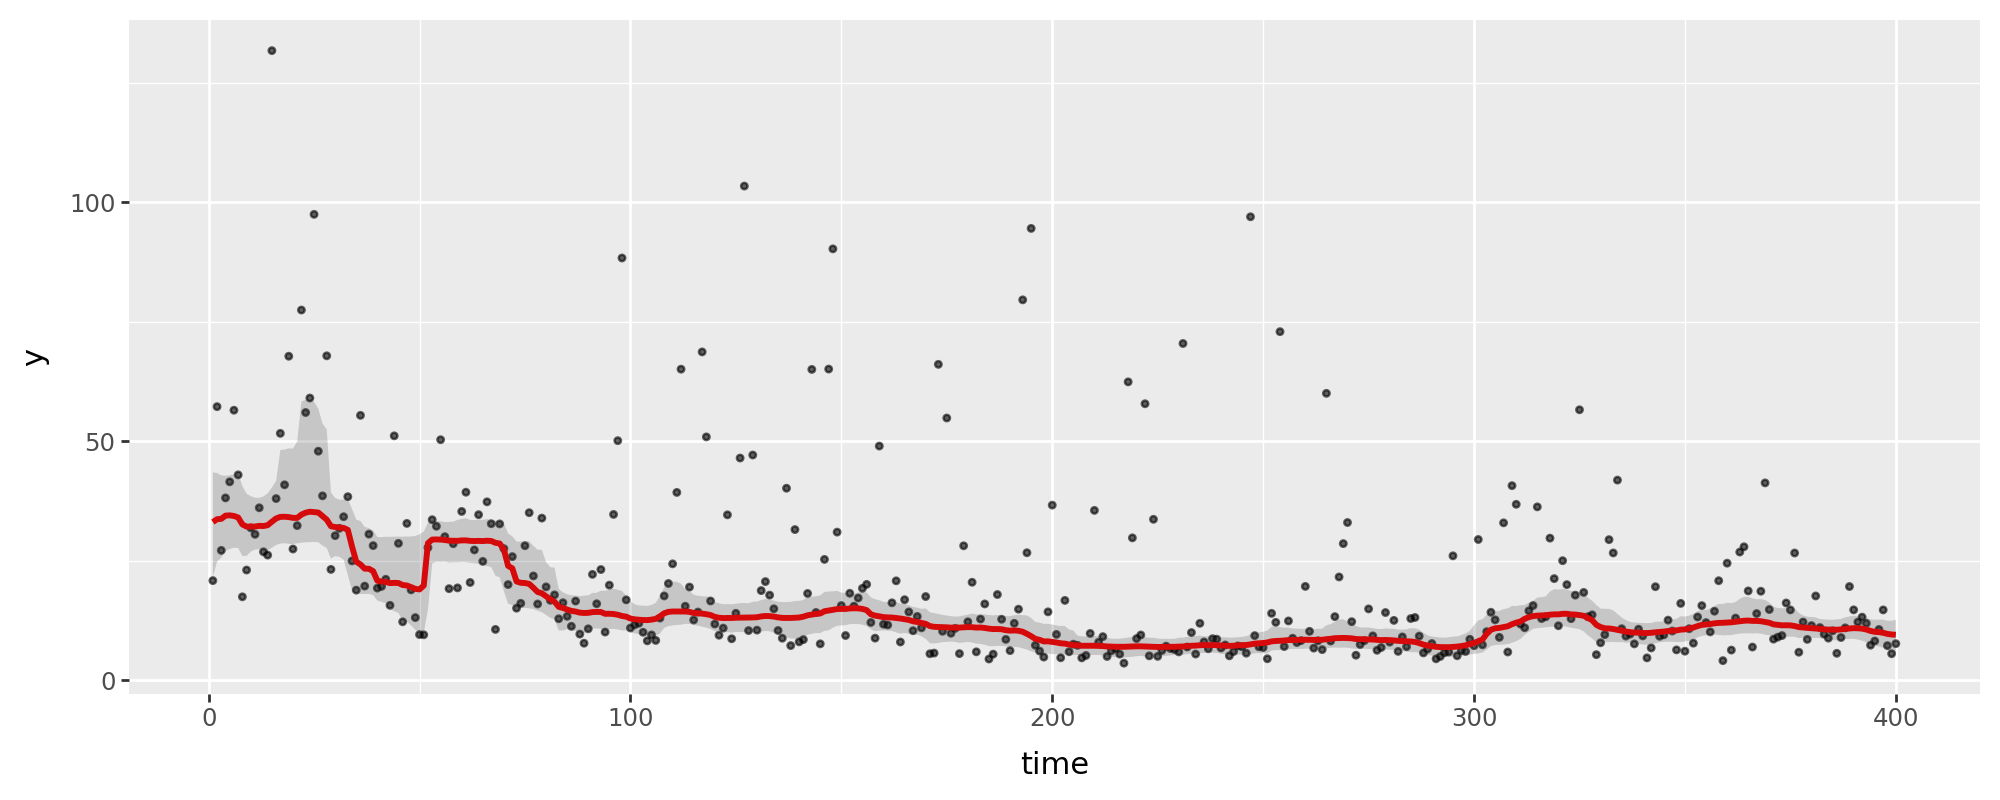

In [ ]:
percentile["y"] = y
percentile["time"] = range(1, len(percentile)+1)
(
    ggplot(percentile, aes(x="time"))
    + geom_point(aes(y="y"), alpha=0.6, size=0.8)
    + geom_line(aes(y="fit"), size=1.2, color="red")
    + geom_ribbon(aes(ymin="lwr", ymax="upr"), alpha=0.2)
    + theme(figure_size=(10, 4))
    + ggtitle("")
)

In [ ]:
fit

<stan.Fit>
Parameters:
    mu: (400,)
    mu_zero: ()
    sigma_w: ()
    sigma_v: ()
Draws: 4000

In [ ]:
az.plot_trace(fit["b_1"])

AssertionError: b_1

In [ ]:
az.summary(fit).query("r_hat > 1.1")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[39],21.808,3.634,17.119,30.054,1.045,0.789,17.0,24.0,1.16
mu[40],21.576,3.630,16.977,30.046,1.089,0.826,16.0,18.0,1.17
mu[41],21.488,3.689,17.011,30.322,1.109,0.845,16.0,18.0,1.18
mu[42],21.199,3.949,15.850,30.280,1.144,0.877,17.0,22.0,1.17
mu[43],21.238,4.162,15.258,30.262,1.131,0.866,18.0,35.0,1.15
mu[44],21.174,4.319,14.891,30.262,1.136,0.871,19.0,33.0,1.15
mu[45],20.600,4.667,13.723,30.457,1.198,0.936,20.0,38.0,1.14
mu[46],20.598,4.856,13.031,30.250,1.190,0.926,21.0,49.0,1.14
mu[47],20.235,5.043,12.538,30.426,1.244,0.969,20.0,40.0,1.14
mu[48],19.888,5.641,11.220,30.385,1.323,1.027,20.0,28.0,1.14


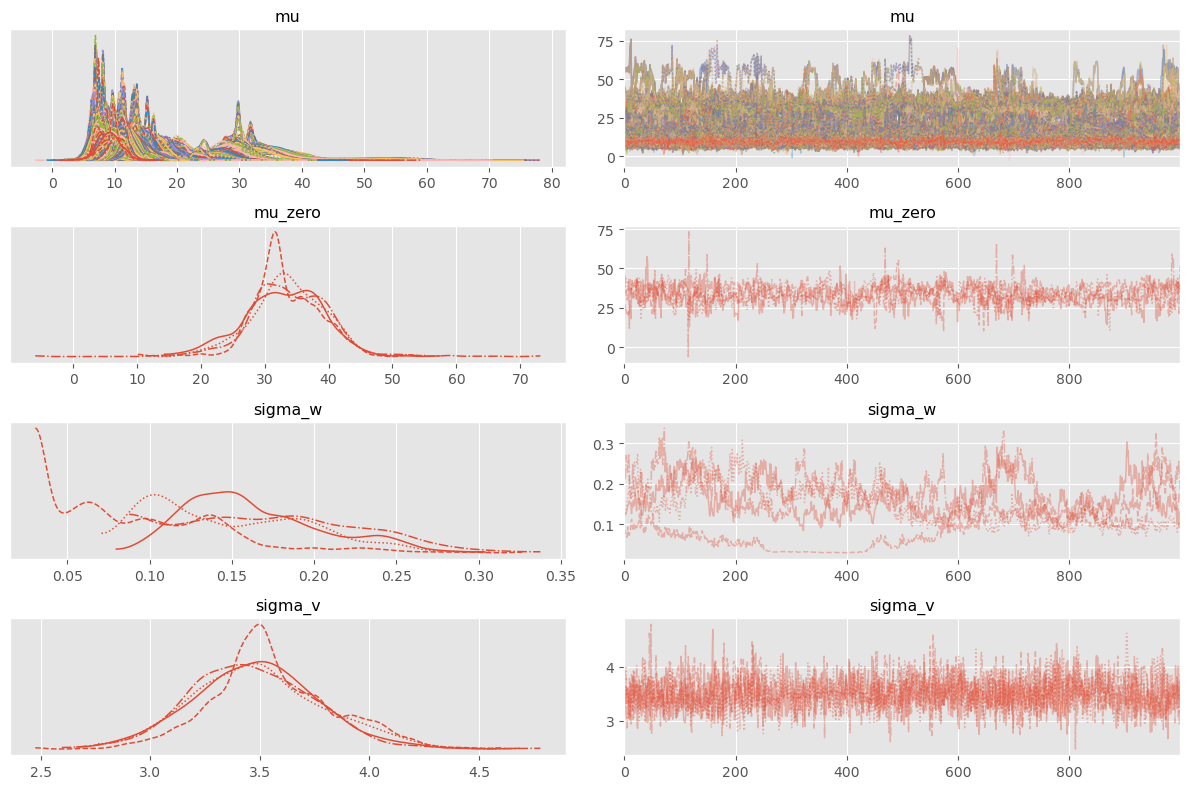

In [ ]:
az.plot_trace(fit)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,3))
plt.plot(fit["y_pred"].mean(axis=1))
plt.figure(figsize=(8,3))

plt.plot(y)

AssertionError: y_pred

<Figure size 800x300 with 0 Axes>

In [ ]:
# https://qiita.com/kromiii/items/c17070e3b242b0d62c39
def waic(fit):
    log_lik = fit['log_lik']
    lppd = np.log(np.exp(log_lik).mean(axis=0)).sum()
    p_waic = np.var(log_lik, axis=0).sum()
    waic = -2*lppd + 2*p_waic
    return round(waic, 3)

In [ ]:
waic(fit)

29611.191